# Geneformer for cell class prediction and data projection

This notebook provides examples to utilize the CELLxGENE-maintained fine-tuned Geneformer model with user data. For more information on the model please refer to the [Census model page](https://cellxgene.cziscience.com/census-models).

**IMPORTANT:** This tutorial requires cellxgene-census package version 1.9.1 or later.

**Contents**

1. Requirements.
1. Preparing data and model.
1. Using the Geneformer fine-tuned model for **cell subclass inference**.
1. Using the Geneformer fine-tuned model for **data projection**.

> ⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Requirements

### System requirements

To run this notebook the following are required:

- Unix system.
- A system with one or more GPUs is highly recommended.
- [AWS command-line interface](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html).
- [Geneformer Python package](https://huggingface.co/ctheodoris/Geneformer) and its dependencies.
- CELLxGENE Census package.

### Downloading example data

Throughout the notebook the 10X PBMC 3K dataset will be used, you can download it via the following shell commands.


In [1]:
!mkdir -p data
!wget -nv -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

2023-12-14 15:18:48 URL:https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [7621991/7621991] -> "data/pbmc3k_filtered_gene_bc_matrices.tar.gz" [1]


### Downloading the fine-tuned Geneformer model

The model is currently hosted in S3, you can find out more deatails in the [Census model page](https://cellxgene.cziscience.com/census-models).

Additional information, including its S3 URI, is also included in the metadata of the corresponding embeddings inside Census. These metadata can be obtained as follows.

In [2]:
import cellxgene_census
import json

census = cellxgene_census.open_soma(census_version="2023-12-15")

geneformer_info = census["census_data"]["homo_sapiens"].ms["RNA"].obsm["geneformer"].metadata
geneformer_info = json.loads(geneformer_info["CxG_embedding_info"])

In [3]:
geneformer_info["model_link"]

's3://cellxgene-contrib-public/models/geneformer/2023-10-23/homo_sapiens/fined-tuned-model/'

And we can download it via the AWS CLI.

In [4]:
!aws s3 sync s3://cellxgene-contrib-public/models/geneformer/2023-10-23/homo_sapiens/fined-tuned-model/ ./fine_tuned_geneformer  --no-progress --only-show-errors

### Importing required packages

Finally all the required packages are loaded.

In [5]:
import warnings

warnings.filterwarnings("ignore")

from transformers import BertForSequenceClassification
from transformers import Trainer
from geneformer import DataCollatorForCellClassification
from geneformer import TranscriptomeTokenizer
from geneformer import EmbExtractor
from cellxgene_census.experimental import get_embedding
from cellxgene_census.experimental.ml.huggingface import GeneformerTokenizer
import datasets
import json
import os
import scanpy as sc
import numpy as np
import cellxgene_census
import tiledbsoma

## Preparaing data and model

### Preparaing single-cell data

Let's load the test data. In preparation to use with Geneformer the following: 
- Sets the index as the ENSEMBL ID and stores it in the `obs` column `"ensembl_id"`
- Adds read counts to the `obs` column `"n_counts"`
- Adds and ID column to be used for joining later in the  `obs` column `"joinid"`

Then we write the resulting H5AD file to disk.

In [6]:
adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))

h5ad_dir = "./data/h5ad/"

if not os.path.exists(h5ad_dir):
    os.makedirs(h5ad_dir)

adata.write(h5ad_dir + "pbmcs.h5ad")

Now we can tokenize the test data using Geneformer's tokenizer, while keeping track of `"joinid"` for future joining.

In [7]:
token_dir = "data/tokenized_data/"

if not os.path.exists(token_dir):
    os.makedirs(token_dir)

tokenizer = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid"})
tokenizer.tokenize_data(
    data_directory=h5ad_dir,
    output_directory=token_dir,
    output_prefix="pbmc",
    file_format="h5ad",
)

Tokenizing data/h5ad/pbmcs.h5ad
data/h5ad/pbmcs.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2700 [00:00<?, ? examples/s]

### Preparaing data from model

Then let's fetch the mapping dictionary between Geneformer IDs and the associated cell subclass labels. This information is stored along the fine-tuned model.

In [8]:
model_dir = "./fine_tuned_geneformer/model/1250_per_cell_type_10epochs_bf16/"
model_dir = "./fine_tuned_geneformer/model/2500_per_cell_type_8epochs/"
label_mapping_dict_file = os.path.join(model_dir, "label_to_cell_subclass.json")

with open(label_mapping_dict_file, "r") as fp:
    label_mapping_dict = json.load(fp)

This dictionary contains all the possible cell labels available for the model, and the predictions on the section below will use these labels.

In [9]:
label_mapping_dict

{'0': 'B cell',
 '1': 'BEST4+ intestinal epithelial cell, human',
 '2': 'CD4-positive, alpha-beta T cell',
 '3': 'CD8-positive, alpha-beta T cell',
 '4': 'CNS neuron (sensu Vertebrata)',
 '5': 'GABAergic neuron',
 '6': 'T cell',
 '7': 'abnormal cell',
 '8': 'adventitial cell',
 '9': 'animal cell',
 '10': 'bone cell',
 '11': 'cardiocyte',
 '12': 'cell of skeletal muscle',
 '13': 'ciliated cell',
 '14': 'columnar/cuboidal epithelial cell',
 '15': 'connective tissue cell',
 '16': 'contractile cell',
 '17': 'defensive cell',
 '18': 'dendritic cell',
 '19': 'duct epithelial cell',
 '20': 'ecto-epithelial cell',
 '21': 'ectodermal cell',
 '22': 'endo-epithelial cell',
 '23': 'endocrine cell',
 '24': 'endothelial cell',
 '25': 'epithelial cell',
 '26': 'epithelial cell of lung',
 '27': 'epithelial cell of pancreas',
 '28': 'epithelial cell of urethra',
 '29': 'eukaryotic cell',
 '30': 'exocrine cell',
 '31': 'fat cell',
 '32': 'fibroblast',
 '33': 'germ cell',
 '34': 'glandular epithelial cel

## Using the Geneformer fine-tuned model for cell class inference

### Loading tokenized data

Let's load the tokenized test data.

In [10]:
dataset = datasets.load_from_disk(token_dir + "pbmc.dataset")
dataset

Dataset({
    features: ['input_ids', 'joinid', 'length'],
    num_rows: 2700
})

We add a dummy cell metadata column `"label"` needed for Geneformer to make predictions.

In [11]:
dataset
dataset = dataset.add_column("label", [0] * len(dataset))

### Performing inference of cell class

Now we can load the model and run the inference workflow.

> ⚠️ Note, this step will be slow with CPUs, a machine with one GPU is recommended

In [12]:
# reload pretrained model
model = BertForSequenceClassification.from_pretrained(model_dir)
# create the trainer
trainer = Trainer(model=model, data_collator=DataCollatorForCellClassification())
# use trainer
predictions = trainer.predict(dataset)

And finally we select the most likely cell class based on the probability vector from the predictions of each cell in our test data.

In [13]:
predicted_label_ids = np.argmax(predictions.predictions, axis=1)
predicted_labels = [label_mapping_dict[str(i)] for i in predicted_label_ids]

### Inspecting inference results

Then we add the prediction back to our loaded AnnData test dataset.

In [14]:
adata.obs["predicted_cell_subclass"] = predicted_labels

And it's ready for inspecting the predictions. Let's visualize the predictions on the UMAP space, the following is a basic processing workflow to derive a UMAP representation, of the data.

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

Let's also add the original cell type annotations as obtained in [Scapy's annotation tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) of the same data. 

In [16]:
sc.tl.leiden(adata)
original_cell_types = [
    "CD4-positive, alpha-beta T cell (1)",
    "CD4-positive, alpha-beta T cell (2)",
    "CD14-positive, monocyte",
    "B cell (1)",
    "CD8-positive, alpha-beta T cell",
    "FCGR3A-positive, monocyte",
    "natural killer cell",
    "dendritic cell",
    "megakaryocyte",
    "B cell (2)",
]
adata.rename_categories("leiden", original_cell_types)

These are the original annotations.

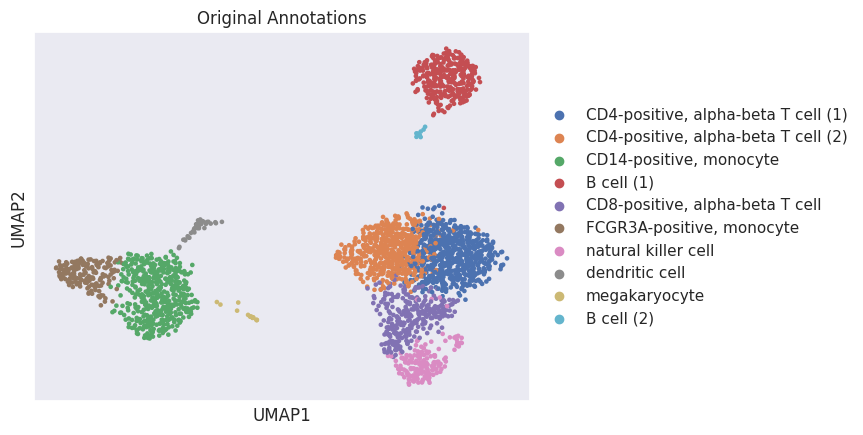

In [17]:
sc.pl.umap(adata, color="leiden", title="Original Annotations")

And these are the predicted annotations.

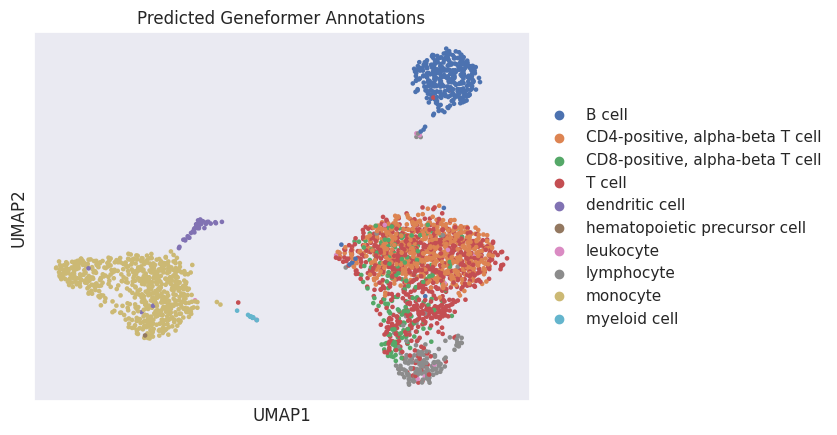

In [18]:
sc.pl.umap(adata, color="predicted_cell_subclass", title="Predicted Geneformer Annotations")

## Using the Geneformer fine-tuned model for data projection

### Generating Geneformer embeddings for 10X PBMC 3K data

To project new data, for example the 10X PBMC 3K data, into the Census embedding space from Geneformer's fine-tune model, we can use `EmbExtractor` from the [Geneformer](https://huggingface.co/ctheodoris/Geneformer) package as follows.

We first need to get the number of categories (cell subclasses) present in the model.

In [19]:
n_classes = len(label_mapping_dict)

Then we can run the `EmbExtractor`, which randomize the cells during the process and thus we keep track of `"joinid"`.

> ⚠️ Note, this step will be slow with CPUs, a machine with one GPU is recommended

In [20]:
output_dir = "data/geneformer_embeddings"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=n_classes,
    max_ncells=None,
    emb_label=["joinid"],
    emb_layer=-1,
    forward_batch_size=30,
    nproc=8,
)

embs = embex.extract_embs(
    model_directory=model_dir,
    input_data_file=token_dir + "pbmc.dataset",
    output_directory=output_dir,
    output_prefix="emb",
)

  0%|          | 0/90 [00:00<?, ?it/s]

Then we simply re-order the embeddings based on `"joinid"` and then merge them to the original AnnData

In [21]:
embs = embs.sort_values("joinid")
adata.obsm["geneformer"] = embs.drop(columns="joinid").to_numpy()

Let's take a look at these Geneformer embeddings in a UMAP representation

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="geneformer")
sc.tl.umap(adata)

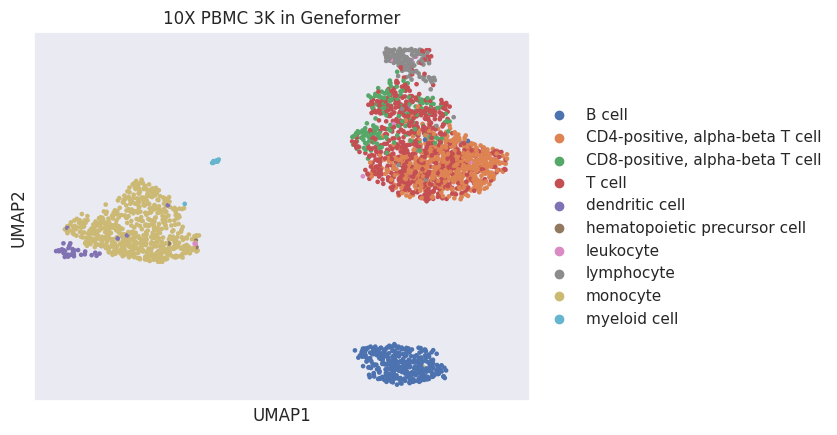

In [23]:
sc.pl.umap(adata, color="predicted_cell_subclass", title="10X PBMC 3K in Geneformer")

### Joining Geneformer embeddings from 10X PBMC 3K data with other Census datasets

There are multiple datasets in Census from PBMCs, and all human Census data has pre-calculated Geneformer embeddings, so now we can join the embeddings we generated above from the 10X PBMC 3K dataset with Census data.

Let's grab a few PBMC datasets from Census and request the Geneformer embeddings.

In [24]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

# Some PBMC data from these collections
# 1. https://cellxgene.cziscience.com/collections/c697eaaf-a3be-4251-b036-5f9052179e70
# 2. https://cellxgene.cziscience.com/collections/f2a488bf-782f-4c20-a8e5-cb34d48c1f7e

dataset_ids = ["fa8605cf-f27e-44af-ac2a-476bee4410d3", "3c75a463-6a87-4132-83a8-c3002624394d"]

adata_census = cellxgene_census.get_anndata(
    census=census,
    measurement_name="RNA",
    organism="Homo sapiens",
    obs_value_filter=f"dataset_id in {dataset_ids}",
    obsm_layers=["geneformer"],
)

To simplify let's select the genes that are also present in the 10X PBMC 3K dataset.

In [25]:
adata_census.var_names = adata_census.var["feature_id"]
shared_genes = list(set(adata.var_names) & set(adata_census.var_names))
adata_census = adata_census[:, shared_genes]

And take a subset of these cells, let's take 3K cells to match the size of the test data. 

In [26]:
index_subset = np.random.choice(adata_census.n_obs, size=3000, replace=False)
adata_census = adata_census[index_subset, :]

Now we can join these Census data to the 10X PBMC 3K data

In [27]:
adata_census.obs["dataset"] = "Census - " + adata_census.obs["dataset_id"].astype(str)
adata.obs["dataset"] = "10X PBMC 3K"
adata.obs["cell_type"] = "Predicted - " + adata.obs["predicted_cell_subclass"].astype(str)

adata_joined = sc.concat([adata, adata_census], join="outer", label="batch")

Let's now inspect all of the cells in the UMAP space.

In [28]:
sc.pp.neighbors(adata_joined, n_neighbors=10, n_pcs=40, use_rep="geneformer")
sc.tl.umap(adata_joined)

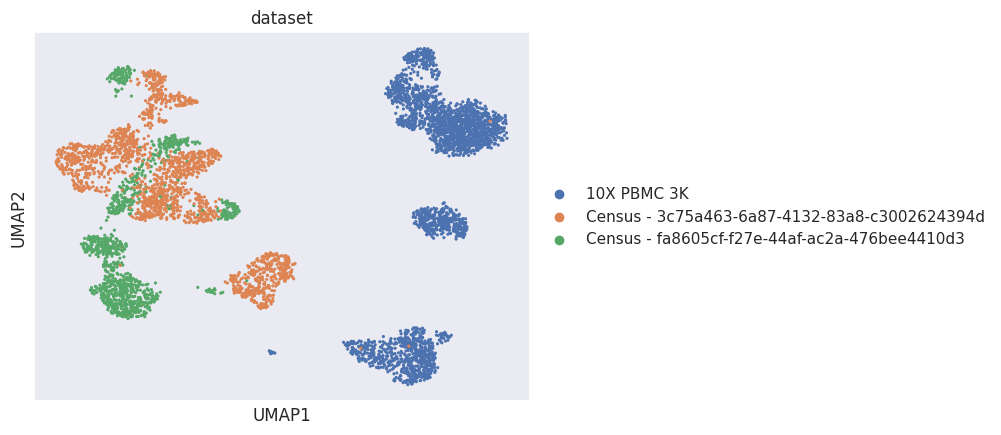

In [29]:
sc.pl.umap(adata_joined, color="dataset")

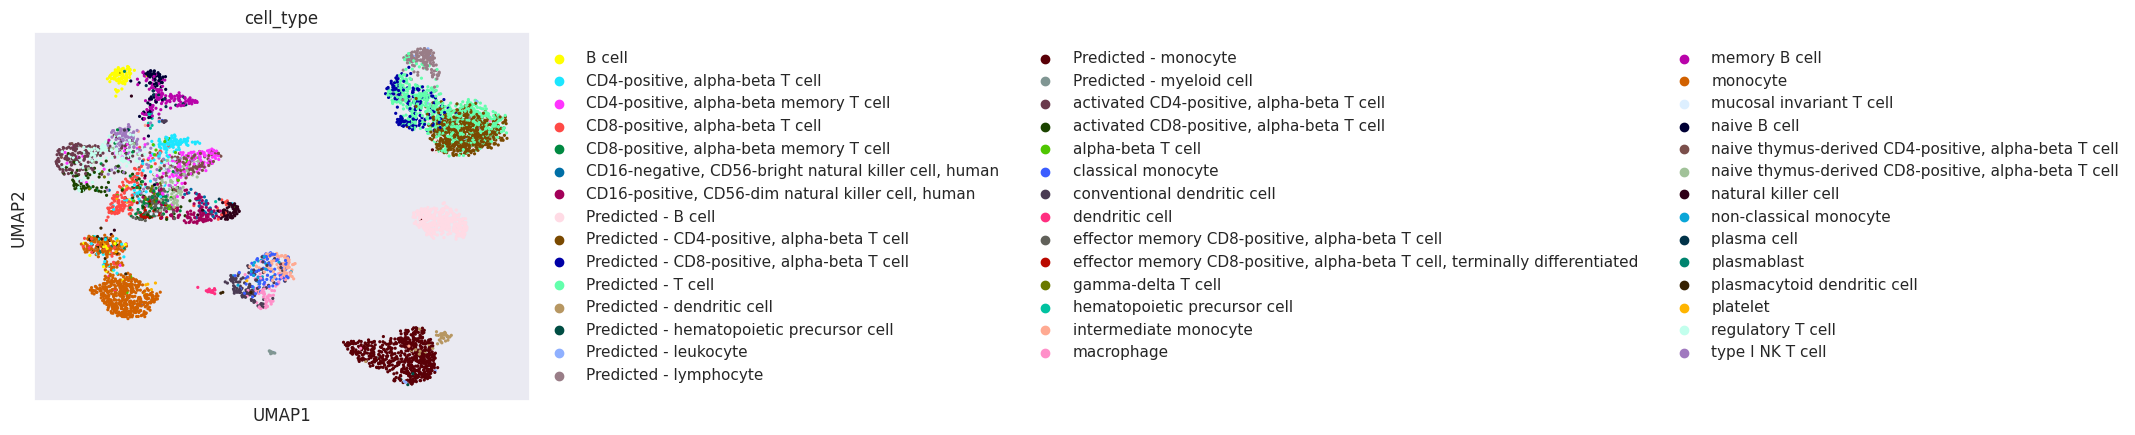

In [30]:
sc.pl.umap(adata_joined, color="cell_type")